# Custom Optimization Problem

This notebook demonstrates how to define and optimize custom problems using the optimization algorithms implemented in this repository.

We illustrate two 2D optimization scenarios:

1. **Sphere Function** – a smooth, convex problem.
2. **Himmelblau Function** – a multimodal function with multiple global optima.

Each function is defined, wrapped into a compatible problem class, and optimized using two PSO variants:

- **GBEST PSO** – a global best single-solution variant.
- **r3PSO** – a ring-topology multi-solution variant (a form of lbest PSO).

> 📌 **Note:** Problems are defined using a standardized interface (`BenchmarkFunction` or `OptimizationProblem`) to ensure compatibility across all implemented optimization algorithms. This design makes it easy to run consistent experiments using a wide range of solvers.

In [ ]:
import sys
import numpy as np

# Append the path to access the core library
PATH = "../"
if PATH not in sys.path:
    sys.path.append(PATH)

from optimization.problems.types import OptimizationProblem, BenchmarkFunction
from optimization.algorithms.pso.variants import get_lbest_pso, get_gbest_pso
from optimization.utils.plot import plot_contour, plot_contour_gif
from optimization.algorithms.utils.callbacks import SolutionTracer
import matplotlib.pyplot as plt

## Problem Definition

We define two problems:

- **Sphere Function**: A simple convex problem often used to test convergence.
- **Himmelblau Function**: A multimodal function with multiple known optima.

Each problem is defined as a callable evaluator with the signature `(N, D) -> N` and wrapped in a `BenchmarkFunction`.

In [29]:
## Define the 2D Sphere function: a simple convex benchmark problem
sphere_bounds = [[-5.12, 5.12], [-5.12, 5.12]]
sphere_fn = lambda X: np.power(X, 2).sum(axis=1)  # Evaluator must accept an (N, D) matrix and return shape (N,)

## BenchmarkFunction is used when global optima are known, e.g., for synthetic benchmark problems
sphere_problem = BenchmarkFunction(
    name="Custom Sphere",
    bounds=sphere_bounds,
    is_maximization=False,
    evaluator=sphere_fn,
    global_optima=[[0, 0]],
)

## If the global optimum is unknown (as is often the case in real-world problems),
## use OptimizationProblem instead, which omits the need to specify known optima:
#
# sphere_problem = OptimizationProblem(
#     name="Custom Sphere",
#     bounds=sphere_bounds,
#     is_maximization=False,  # Set to True if the objective should be maximized
#     evaluator=sphere_fn
# )

In [30]:
himmelblau_bounds = [[-6, 6], [-6, 6]]
himmelblau_fn = lambda X: 200 - (((X[:, 0] ** 2) + X[:, 1] - 11) ** 2) - ((X[:, 0] + (X[:, 1] ** 2) - 7) ** 2)

himmelblau_problem = BenchmarkFunction(
    name="Custom Himmelblau",
    bounds=himmelblau_bounds,
    is_maximization=True,
    evaluator=himmelblau_fn,
    global_optima=[
        [3.0, 2.0],
        [-2.805118, 3.131312],
        [-3.779310, -3.283186],
        [3.584428, -1.848127]
    ]
)

## Choose Optimization Problem

Uncomment the one you want to test. In this example, we use the Himmelblau function.

In [31]:
# opt_problem = sphere_problem
opt_problem = himmelblau_problem

## Run Optimization

We use two variants of Particle Swarm Optimization (PSO):

- `GBEST PSO`: The canonical PSO algorithm (single-solution).
- `r3PSO`: A local topology-based PSO with a neighborhood size of 3 (multi-solution).

To track the optimization process over time, we attach a `SolutionTracer` callback to each algorithm.
This allows us to capture and visualize how the population evolves across generations.

In [32]:
lbest_pso = get_lbest_pso(neighborhood_size=3)  # r3PSO
gbest_pso = get_gbest_pso()

algorithms = [lbest_pso, gbest_pso]

MAX_GENERATIONS = 100
POP_SIZE = 50
EVALS = MAX_GENERATIONS * POP_SIZE

In [33]:
tracers = {}
for alg in algorithms:
    tracer = SolutionTracer(population_callbacks={
        "solutions": lambda population: population.solutions.copy(),
        "penalized_objs": lambda population: population.solutions_objective_values.copy(),
    })
    
    alg.compile(opt_problem, initializer_kwargs={"n_individuals": POP_SIZE})
    alg.optimize(EVALS, callbacks=[tracer], verbose=1)
    tracers[alg.name] = tracer

r3pso optimizing Custom Himmelblau 2D Max FES: 5000:   0%|          | 0/5000 [00:00<?, ?it/s]

GBEST PSO optimizing Custom Himmelblau 2D Max FES: 5000:   0%|          | 0/5000 [00:00<?, ?it/s]

## Visualize the Solutions

We use contour plots to visualize the identified solutions against the landscape of the objective function.

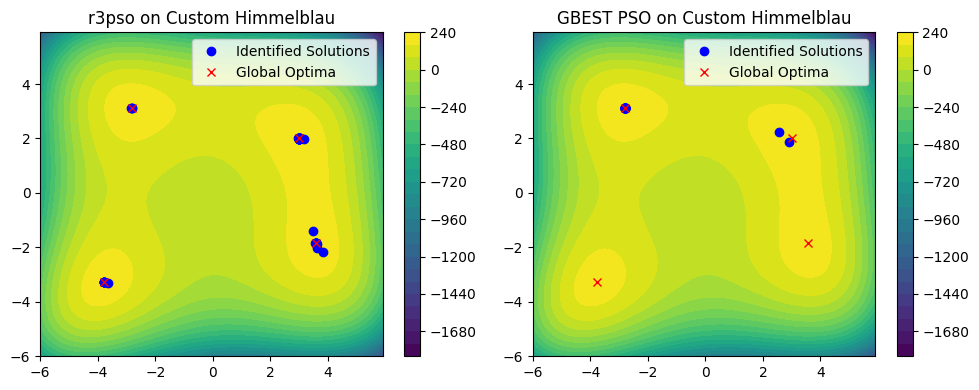

In [34]:
fig, axes = plt.subplots(1, len(algorithms), figsize=(5 * len(algorithms), 4))

# Ensure axes is always a list
axes = axes if isinstance(axes, np.ndarray) else [axes]

for i, alg in enumerate(algorithms):
    plot_contour(
        func=opt_problem,
        ranges=opt_problem.bounds,
        increments=0.1,
        points=alg.population.solutions,
        special_points=opt_problem.global_optima,
        title=f"{alg.name} on {opt_problem.name}",
        points_label="Identified Solutions",
        special_points_label="Global Optima",
        ax=axes[i]
    )

plt.tight_layout()
plt.show()

## Animate Optimization History

To better understand how the population moves over the search space, we animate the trajectory of solutions using `plot_contour_gif`.

The animation shows the evolving population over the landscape of the objective function, helping visualize convergence behavior and exploration-exploitation dynamics.

In [ ]:
history = np.array(tracers[algorithms[0].name].history["solutions"])

gif = plot_contour_gif(
    func=opt_problem,
    ranges=opt_problem.bounds,
    increments=0.1,
    population_history=history,
    special_points=opt_problem.global_optima,
    title="Optimization Evolution"
)

gif